<h1 style="text-align:center">X-Ray Pneumonia Classifing</h1>

## Preporcessing

### Imports and set up one seed for all

In [ ]:
import os
import copy
import torch
import random
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.datasets as datasets 
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from PIL import Image

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)

seed = 42
set_seed(seed)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

In [ ]:
# First try of preparing the data

# path_train_normal = 'chest_xray/train/NORMAL/'
# path_train_pneumonia = 'chest_xray/train/PNEUMONIA/'
# path_test_normal = 'chest_xray/test/NORMAL/'
# path_test_pneumonia = 'chest_xray/test/PNEUMONIA/'

# pil_train = []
# y_train = []

# pil_test = []
# y_test = []


# for file in os.listdir(path_train_normal):
#     img = copy.deepcopy(Image.open(path_train_normal + file))
#     y_train.append(0)
#     pil_train.append(img)
    
# for file in os.listdir(path_train_pneumonia):
#     img = copy.deepcopy(Image.open(path_train_pneumonia + file))
#     y_train.append(1)
#     pil_train.append(img)
    
# for file in os.listdir(path_test_normal):
#     img = copy.deepcopy(Image.open(path_test_normal + file))
#     y_test.append(0)
#     pil_test.append(img)
    
# for file in os.listdir(path_test_pneumonia):
#     img = copy.deepcopy(Image.open(path_test_pneumonia + file))
#     y_test.append(1)
#     pil_test.append(img)

# np.array(pil_train[0]).shape

### Class for load images

In [ ]:
class XRayImage(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        path, _ = self.samples[index]
        target = 0
        if 'PNEUMONIA' in path:
            target = 1
        
        return sample, target

### Transforming images

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=550, scale=(0.8, 1.0)),
#     transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(500),
    transforms.Grayscale(),
#     transforms.ColorJitter(),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(550),
    transforms.CenterCrop(500),
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = XRayImage('chest_xray/train', transform=train_transforms)
val_dataset = XRayImage('chest_xray/val', transform=test_transforms)
test_dataset = XRayImage('chest_xray/test', transform=test_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train_dataset.targets), train_dataset.targets)

In [ ]:
# for batch_idx, (data, labels) in enumerate(train_dataloader):
#     data, labels = data.to(device), labels.to(device)
#     print(labels[12])
#     plt.imshow(data[12].cpu().permute(1, 2, 0).numpy(), cmap='gray')
#     break

### Checking if image rotations is needed

In [ ]:
# plt.figure(figsize=(20, 12))
# for i in range(0, 10):
#     plt.subplot(2, 5, i+1)
#     for batch_idx, (data, labels) in enumerate(train_dataloader):
#         image = data[0]
#         dic = {0:'NORMAL', 1:'PNEUMONIA'}
#         plt.title(dic.get(labels.cpu().numpy()[0]))
#         plt.axis('off')
#         plt.imshow(np.squeeze(image.cpu().numpy()),cmap='gray',interpolation='nearest')
# #         plt.imshow(np.squeeze(image.cpu().permute(1, 2, 0).numpy()),cmap='gray',interpolation='nearest')
#         break

# plt.tight_layout()
# plt.show()

## Building a NN

### Covolutional NN model

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.maxp1 = nn.MaxPool2d((2, 2))
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(10816, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x=x.to(device)
        
        x=self.conv1(x)
        x=F.relu(x)
        x=self.maxp1(x)
        
        x=self.conv2(x)
        x=F.relu(x)
        x=self.maxp1(x)
        
        x=self.conv2(x)
        x=F.relu(x)
        x=self.maxp1(x)
        
        x=self.conv3(x)
        x=F.relu(x)
        x=self.maxp1(x)
        
        x=self.conv4(x)
        x=F.relu(x)
        x=self.maxp1(x)
        
        x=self.flat(x)
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        x=F.relu(x)
        x=self.fc3(x)
        return(x)

In [ ]:
# from torchsummary import summary

# model = CNNClassifier()
# summary(model.cuda(), (1, 500, 500))

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    
    return float(num_correct)/float(num_samples)*100

In [ ]:
model = CNNClassifier()
model.to(device)

num_epochs = 55

criterion = nn.CrossEntropyLoss(weight = torch.Tensor(weights).to(device))
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2, verbose=True)

train_accuracy = []
val_accuracy = []
test_accuracy = []
epochs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, (data, targets) in enumerate(train_dataloader):
        # Get data to cuda if possible
        data = data.to(device=device)
#         targets = torch.tensor(targets.unsqueeze(1).numpy(), dtype=torch.float32)
        targets = targets.to(device=device)
        
        # forward
        scores = model(data)
#         print(scores.shape, targets.shape)
        loss = criterion(scores, targets)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient descent or adam step
        optimizer.step()
        if (batch_idx+1) % 50 == 0:
            print(batch_idx+1)
            #print(check_accuracy(train_dataloader, model))
    scheduler.step(loss)
    
    model.eval()
    
    train_accuracy.append(check_accuracy(train_dataloader, model))
    val_accuracy.append(check_accuracy(val_dataloader, model))
    test_accuracy.append(check_accuracy(test_dataloader, model))
    epochs.append(epoch+1)
    print(f'Train accuracy:{train_accuracy[epoch]}, validation accuracy:{val_accuracy[epoch]}, test accuracy:{test_accuracy[epoch]}')
    
    model.train()

Epoch 1/55
50
100
150
200
250
300
350
400
450
500
550
600
650
Train accuracy:82.49616564417178, validation accuracy:75.0, test accuracy:79.16666666666666
Epoch 2/55
50
100
150
200
250
300
350
400
450
500
550
600
650
Train accuracy:92.4463190184049, validation accuracy:68.75, test accuracy:75.64102564102564
Epoch 3/55
50
100
150
200
250
300
350
400
450
500
550
600
650
Train accuracy:91.90950920245399, validation accuracy:75.0, test accuracy:76.12179487179486
Epoch 4/55
50
100
150
200
250
300
350
400
450
500
550
600
650
Epoch     4: reducing learning rate of group 0 to 3.0000e-04.
Train accuracy:93.48159509202453, validation accuracy:75.0, test accuracy:76.76282051282051
Epoch 5/55
50
100
150
200
250
300
350
400
450
500
550
600
650
Train accuracy:94.86196319018406, validation accuracy:62.5, test accuracy:76.28205128205127
Epoch 6/55
50
100
150
200
250
300
350
400
450
500
550
600
650
Train accuracy:95.39877300613497, validation accuracy:62.5, test accuracy:79.6474358974359
Epoch 7/55
50
1

KeyboardInterrupt: ignored

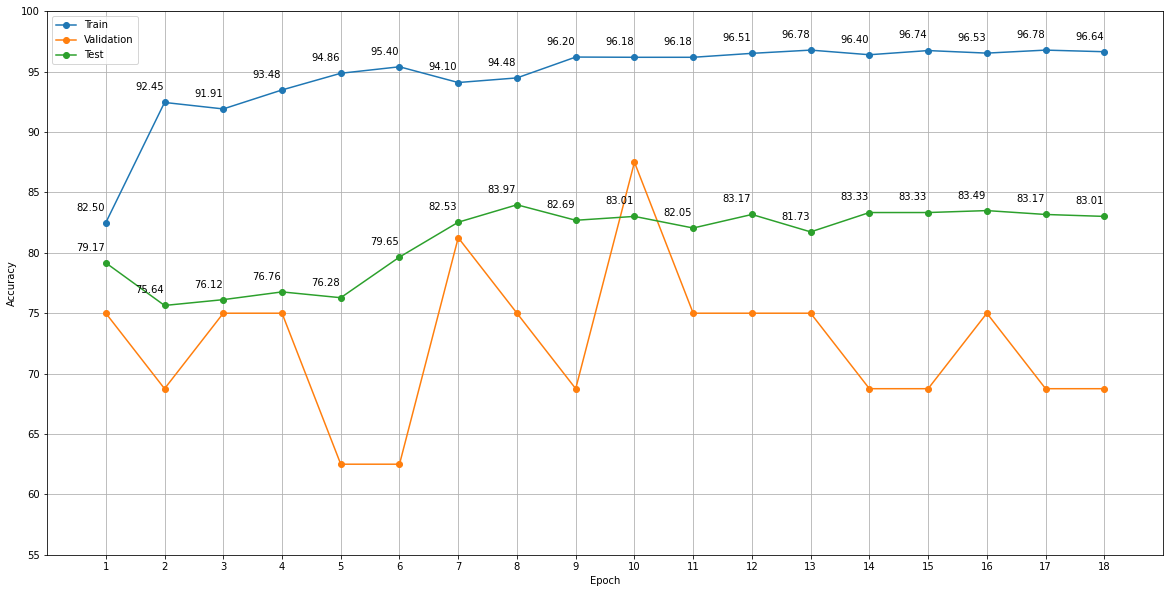

In [ ]:
plt.figure(figsize=(20, 10))
plt.axis([0, 19, 55, 100])
plt.xticks(epochs)
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, train_accuracy, '-o', label='Train')
plt.plot(epochs, val_accuracy, '-o', label='Validation')
plt.plot(epochs, test_accuracy, '-o', label='Test')
for i in range(len(epochs)):
    plt.text(i+0.5, train_accuracy[i]+1, f'{train_accuracy[i]:.02f}')
  # plt.text(i+0.5, val_accuracy[i]+1, f'{val_accuracy[i]:.02f}')
    plt.text(i+0.5, test_accuracy[i]+1, f'{test_accuracy[i]:.02f}')
plt.legend()

In [ ]:
model_save_name = 'classifier.pt'
path = f"saved_models/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
loaded_model = CNNClassifier()
loaded_model.load_state_dict(torch.load(f"saved_models/{model_save_name}"))
loaded_model.to('cuda')
loaded_model.eval()

CNNClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=10816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
check_accuracy(test_dataloader, loaded_model)

83.01282051282051